In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import kagglehub
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
from sklearn.utils import resample

In [ ]:
# Download the datatset
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

print("Available files:",os.listdir(path))

# Copy and store the dataset in the colab files
shutil.copy(path+'/'+'kidneyData.csv','/content/')
src=path+'/'+'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
shutil.copytree(src, '/content/', dirs_exist_ok=True)

100%|██████████| 1.52G/1.52G [01:11<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1
Available files: ['kidneyData.csv', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']


'/content/'

In [ ]:
# Import the CSV file
df=pd.read_csv('/content/kidneyData.csv')
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
# Obtaining the information in the CSV file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


In [ ]:
# Count of missing values in each column
df.isnull().sum()

,0
Unnamed: 0,0
image_id,0
path,0
diag,0
target,0
Class,0


In [ ]:
# Count of categories present in 'Class' column
df['Class'].value_counts()

,count
Class,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [ ]:
# Count of categories present in 'target' column
df['target'].value_counts()

,count
target,
1,5077
0,3709
3,2283
2,1377


In [ ]:
# Count of categories present in 'diag' column
df['diag'].value_counts()

,count
diag,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


In [ ]:
# Create a dataframe consisting the right path to the image and its label
base_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

sub_dirs = ['Tumor', 'Normal', 'Stone', 'Cyst']

data = []

for sub_dir in sub_dirs:
    sub_dir_path = os.path.join(base_dir, sub_dir)
    for image in os.listdir(sub_dir_path):
        if image.endswith('.jpg'):
            image_path = os.path.join(sub_dir_path, image)
            data.append({'image_path': image_path, 'label': sub_dir})

df=pd.concat([df,pd.DataFrame(data)],axis=1)

In [ ]:
# Drop the columns that are not required
columns_to_drop=['Unnamed: 0','path','diag','Class']
df.drop(columns_to_drop,axis=1,inplace=True)

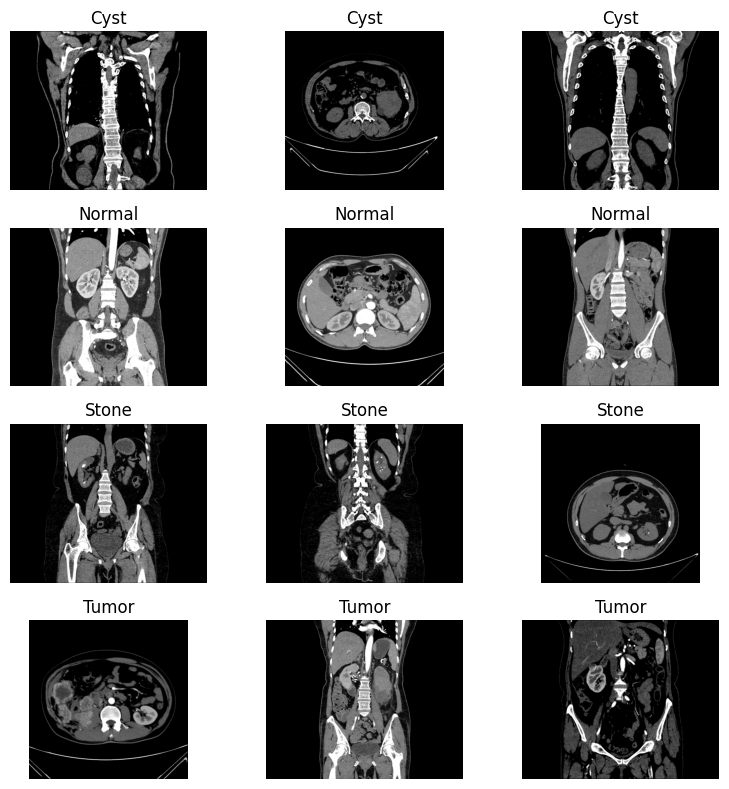

In [ ]:
# Display pictures on different classes of the dataset
classes_to_display = ['Cyst', 'Normal', 'Stone', 'Tumor']
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
axes = axes.flatten()

for i, label in enumerate(classes_to_display):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['image_path']), 3)

    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path)
        axes[i * 3 + j].imshow(img)
        axes[i * 3 + j].axis('off')
        axes[i * 3 + j].set_title(label)
plt.tight_layout()
plt.show()

<ipython-input-12-4b9b9a2e50bc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set3')


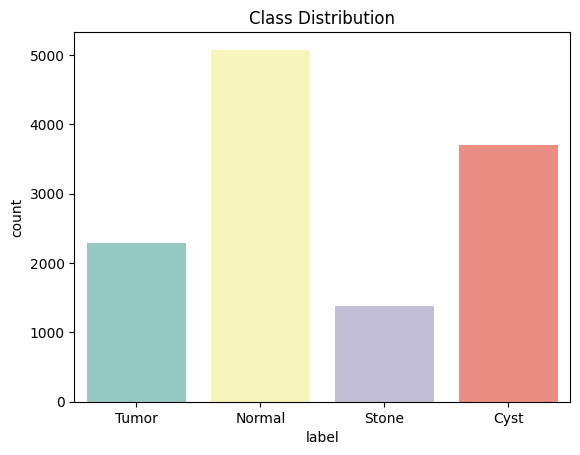

In [ ]:
# Compare the count of the 4 classes (tumor, stone, cyst, normal) in a bar chart
sns.countplot(x='label', data=df, palette='Set3')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Count of each category of label
class_counts=df['label'].value_counts()
print(class_counts)

# Find the maximum class size
max_size = class_counts.max()

# Separate each class
dfs = {label: df[df['label'] == label] for label in df['label'].unique()}

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [ ]:
# Define an image augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

# Augment images in smaller classes
augmented_data = []
for label, data in dfs.items():
    if len(data) < max_size:
        additional_samples = max_size - len(data)
        for i in range(additional_samples):
            original_image_path = random.choice(data['image_path'].tolist())
            img = tf.keras.preprocessing.image.load_img(original_image_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = augment_image(img).numpy()
            augmented_data.append({'image_path': None, 'label': label, 'augmented_image': img})

# Add augmented data to the dataset
augmented_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([df, augmented_df])

label
Tumor     5077
Normal    5077
Stone     5077
Cyst      5077
Name: count, dtype: int64


<ipython-input-21-fae6986c4612>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=balanced_df, palette='Set3')


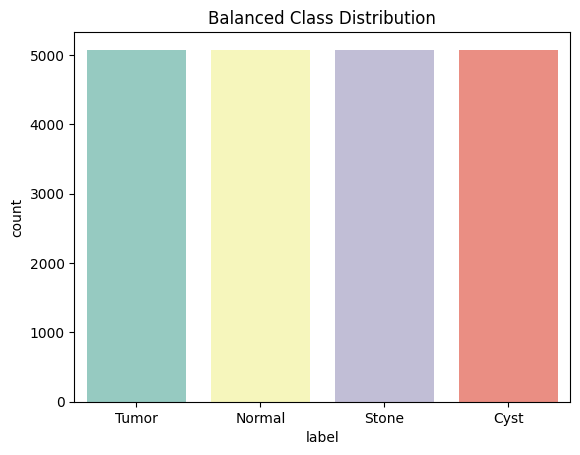

In [ ]:
# Check the distribution of classes after balancing
balanced_counts = balanced_df['label'].value_counts()
print(balanced_counts)

# Visualize the new distribution
sns.countplot(x='label', data=balanced_df, palette='Set3')
plt.title('Balanced Class Distribution')
plt.show()

In [ ]:
# Split the dataset into train, test and validation sets
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Print the number of samples in each set
print("Training set:")
print(train_df['label'].value_counts())
print("\nValidation set:")
print(val_df['label'].value_counts())
print("\nTest set:")
print(test_df['label'].value_counts())

Training set:
label
Cyst      3554
Tumor     3554
Normal    3554
Stone     3553
Name: count, dtype: int64

Validation set:
label
Cyst      762
Stone     762
Normal    761
Tumor     761
Name: count, dtype: int64

Test set:
label
Stone     762
Normal    762
Tumor     762
Cyst      761
Name: count, dtype: int64


In [ ]:
# Image preprocessing
def preprocess_images(df, target_size=(64, 64)):
    images = []
    labels = []
    for _, row in df.iterrows():
        # If it's augmented data
        if row['image_path'] is None:
            img = row['augmented_image']
        else:
            img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0

        # Ensure that the image has the correct shape (64, 64, 3)
        if img.shape != (64, 64, 3):
            img = np.resize(img, (64, 64, 3))

        images.append(img)
        labels.append(row['label'])

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Preprocess datasets
train_images, train_labels = preprocess_images(train_df)
val_images, val_labels = preprocess_images(val_df)
test_images, test_labels = preprocess_images(test_df)

In [ ]:
# One-hot encoding of classes in train, test and validation datasets
encoder = LabelEncoder()
train_labels_encoded = to_categorical(encoder.fit_transform(train_labels))
val_labels_encoded = to_categorical(encoder.transform(val_labels))
test_labels_encoded = to_categorical(encoder.transform(test_labels))

In [ ]:
# Function to compile and train models
def compile_and_train(model, train_images, train_labels, val_images, val_labels, epochs=20, batch_size=32):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_images, train_labels,
        epochs=epochs,
        validation_data=(val_images, val_labels),
        batch_size=batch_size
    )
    return history

In [ ]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

In [ ]:
# Define the ANN model
ann_model = models.Sequential([
    layers.Flatten(input_shape=(64, 64, 3)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Define CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights, exclude the top fully connected layers
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of ResNet50 to keep the pre-trained weights intact
for layer in base_model1.layers[-10:]:
    layer.trainable = False

# Build the model on top of the base ResNet50 model
resnet50_model = models.Sequential([
    base_model1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Load VGG16 with pre-trained ImageNet weights, exclude the top fully connected layers
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of VGG16
for layer in base_model2.layers[-10:]:
    layer.trainable = False

# Build the model on top of the base VGG16 model
vgg16_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6487 - loss: 0.9719 - val_accuracy: 0.8516 - val_loss: 0.3617
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8352 - loss: 0.4052 - val_accuracy: 0.8894 - val_loss: 0.2591
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8585 - loss: 0.3225 - val_accuracy: 0.8976 - val_loss: 0.2391
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8648 - loss: 0.3041 - val_accuracy: 0.9002 - val_loss: 0.2223
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8639 - loss: 0.3099 - val_accuracy: 0.9054 - val_loss: 0.2094
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8798 - loss: 0.2622 - val_accuracy: 0.9097 - val_loss: 0.2046
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8815 - loss: 0.2596 - val_accuracy: 0.8900 - val_loss: 0.2256
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8788 - loss: 0.2721 - val_accuracy: 0.

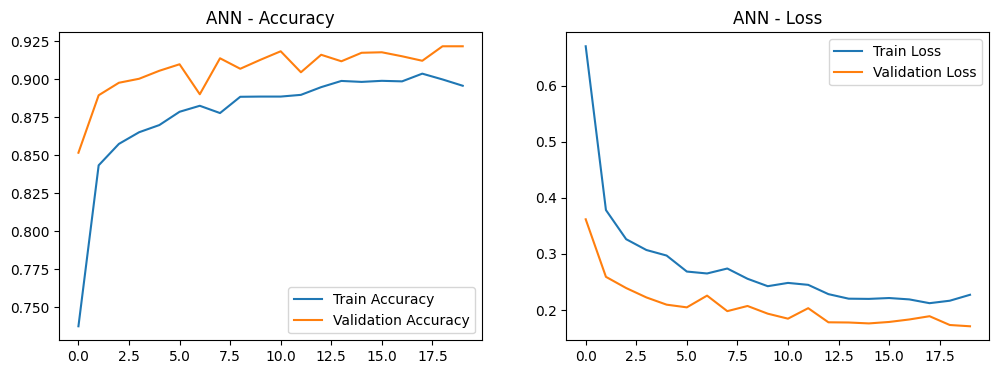

In [ ]:
# Train ANN model
ann_history = compile_and_train(ann_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training ANN model
plot_training_history(ann_history, 'ANN')

#Save ANN model
ann_model.save('/content/ann_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5694 - loss: 0.9750 - val_accuracy: 0.8306 - val_loss: 0.4135
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8222 - loss: 0.4096 - val_accuracy: 0.8880 - val_loss: 0.2617
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8693 - loss: 0.2945 - val_accuracy: 0.9028 - val_loss: 0.2165
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8904 - loss: 0.2379 - val_accuracy: 0.9117 - val_loss: 0.1897
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9021 - loss: 0.2133 - val_accuracy: 0.9127 - val_loss: 0.1891
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9074 - loss: 0.1955 - val_accuracy: 0.9179 - val_loss: 0.1796
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9099 - loss: 0.1819 - val_accuracy: 0.9163 - val_loss: 0.1786
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9134 - loss: 0.1782 - val_accuracy:

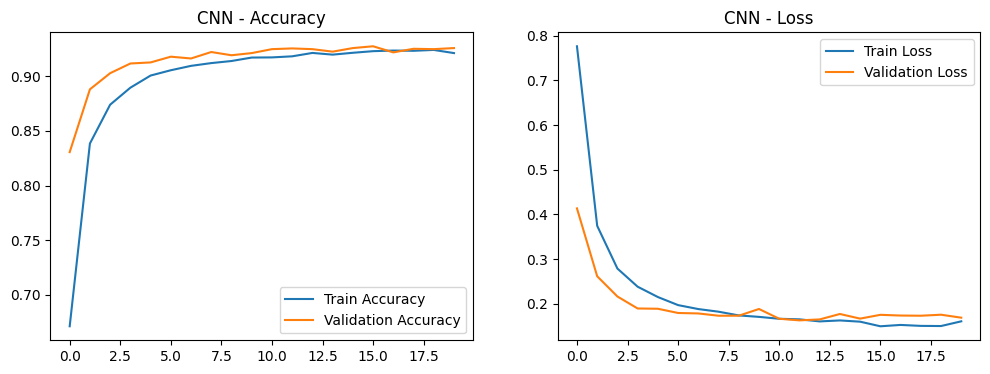

In [ ]:
# Train CNN model
cnn_history = compile_and_train(cnn_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training CNN model
plot_training_history(cnn_history, 'CNN')

# Save CNN model
cnn_model.save('/content/cnn_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 124s 126ms/step - accuracy: 0.6125 - loss: 0.9144 - val_accuracy: 0.2502 - val_loss: 1.9797
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.8368 - loss: 0.4260 - val_accuracy: 0.5269 - val_loss: 2.5812
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.8714 - loss: 0.2883 - val_accuracy: 0.8969 - val_loss: 0.2451
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8870 - loss: 0.2528 - val_accuracy: 0.8624 - val_loss: 0.3461
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.8878 - loss: 0.2698 - val_accuracy: 0.8500 - val_loss: 0.3371
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8966 - loss: 0.2110 - val_accuracy: 0.8936 - val_loss: 0.2727
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.8994 - loss: 0.2287 - val_accuracy: 0.8746 - val_loss: 0.3780
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9016 - loss: 0.2308 

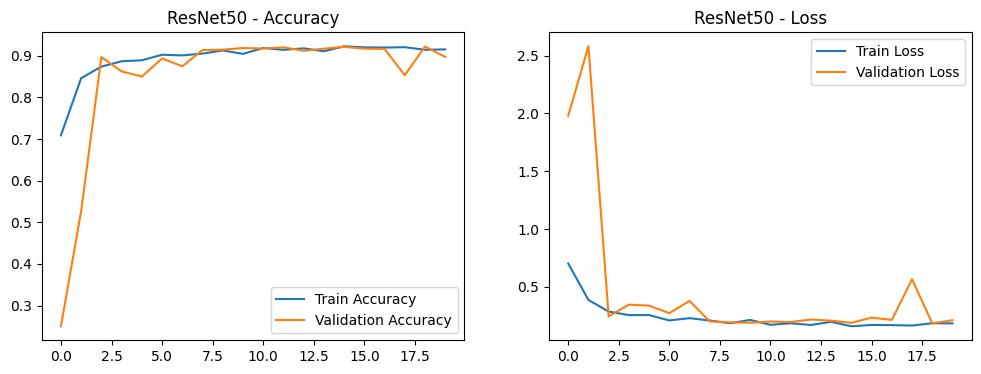

In [ ]:
# Train ResNet50 model
resnet50_history = compile_and_train(resnet50_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# PLot accuracy and loss from training ResNet50 model
plot_training_history(resnet50_history, 'ResNet50')

# Save ResNet50 model
resnet50_model.save('/content/resnet50_model.h5')

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.5028 - loss: 1.0997 - val_accuracy: 0.7072 - val_loss: 0.6697
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.7301 - loss: 0.6410 - val_accuracy: 0.8404 - val_loss: 0.3917
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.8252 - loss: 0.4095 - val_accuracy: 0.8661 - val_loss: 0.3141
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8577 - loss: 0.3232 - val_accuracy: 0.8828 - val_loss: 0.2605
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8795 - loss: 0.2760 - val_accuracy: 0.8795 - val_loss: 0.2830
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.8884 - loss: 0.2540 - val_accuracy: 0.9018 - val_loss: 0.2216
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8971 - loss: 0.2236 - val_accuracy: 0.9035 - val_loss: 0.2285
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.8868 - loss: 0.2390 - 

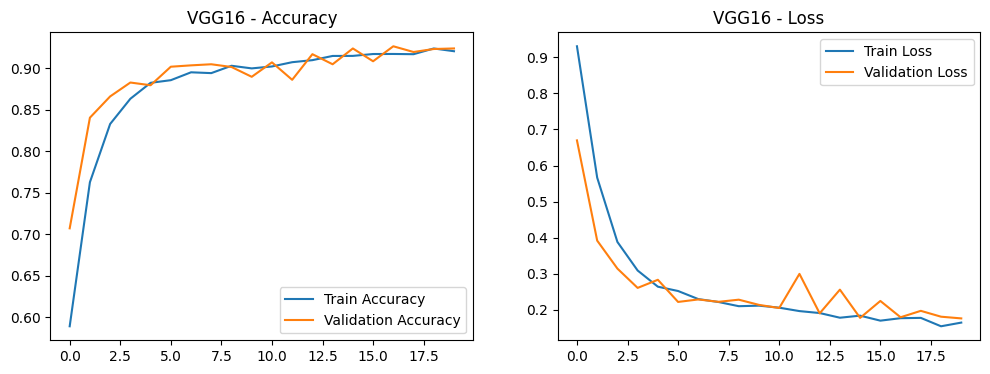

In [ ]:
# Train VGG16 model
vgg16_history = compile_and_train(vgg16_model, train_images, train_labels_encoded, val_images, val_labels_encoded)

# Plot accuracy and loss from training VGG16 model
plot_training_history(vgg16_history, 'VGG16')

# Save VGG16 model
vgg16_model.save('/content/vgg16_model.h5')

In [ ]:
# Evaluation of the models
cnn_accuracy = cnn_model.evaluate(test_images, test_labels_encoded)
ann_accuracy = ann_model.evaluate(test_images, test_labels_encoded)
vgg16_accuracy = vgg16_model.evaluate(test_images, test_labels_encoded)
resnet50_accuracy = resnet50_model.evaluate(test_images, test_labels_encoded)

print(f"ANN Accuracy: {ann_accuracy[1]:.2f}")
print(f"CNN Accuracy: {cnn_accuracy[1]:.2f}")
print(f"ResNet50 Accuracy: {resnet50_accuracy[1]:.2f}")
print(f"VGG16 Accuracy: {vgg16_accuracy[1]:.2f}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9147 - loss: 0.1913
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9086 - loss: 0.2048
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9148 - loss: 0.1779
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8913 - loss: 0.2297
ANN Accuracy: 0.91
CNN Accuracy: 0.92
ResNet50 Accuracy: 0.89
VGG16 Accuracy: 0.92


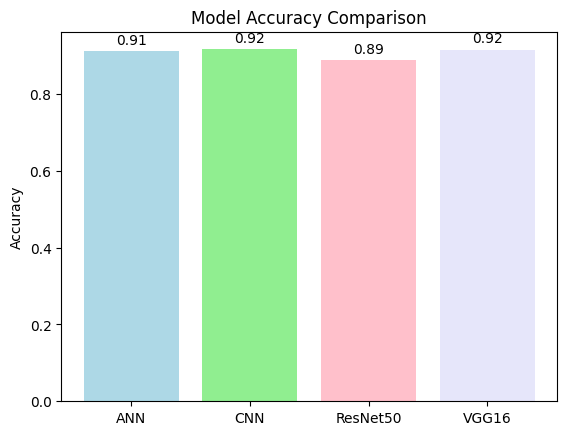

In [ ]:
# Comparison chart
accuracies = [ann_accuracy[1],cnn_accuracy[1], resnet50_accuracy[1], vgg16_accuracy[1]]
dl_models = ['ANN','CNN', 'ResNet50', 'VGG16']

plt.bar(dl_models, accuracies, color=['lightblue','lightgreen','pink','lavender'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# Add text on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Install keras-tuner for hyperparameter tuning
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


In [ ]:
# Define the model-building function for KerasTuner
def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(
            filters=hp.Choice('filters_1', [32, 64]),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            filters=hp.Choice('filters_2', [64, 128]),
            kernel_size=(3, 3),
            activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(
            filters=hp.Int('filters_3', 128, 256, step=64),
            kernel_size=(3, 3),
            activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(
            units=hp.Int('dense_units', 64, 256, step=64),
            activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.6, step=0.1)),
        layers.Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='/content/hyperparam_tuning',
    project_name='cnn_tuning')

In [ ]:
# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
# Perform the search
tuner.search(
    train_images, train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=20,
    callbacks=[stop_early])

Trial 30 Complete [00h 01m 41s]
val_accuracy: 0.9241628646850586

Best val_accuracy So Far: 0.930400550365448
Total elapsed time: 00h 21m 21s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first Conv2D layer is {best_hps.get('filters_1')}
and in the second Conv2D layer is {best_hps.get('filters_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of filters in the first Conv2D layer is 64
and in the second Conv2D layer is 128.
The optimal learning rate is 0.0005.



In [ ]:
# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_images, train_labels_encoded,
    validation_data=(val_images, val_labels_encoded),
    epochs=20,
    callbacks=[stop_early]
)

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5743 - loss: 0.9728 - val_accuracy: 0.8634 - val_loss: 0.3393
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8497 - loss: 0.3465 - val_accuracy: 0.9025 - val_loss: 0.2247
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8892 - loss: 0.2472 - val_accuracy: 0.9156 - val_loss: 0.1910
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9020 - loss: 0.2035 - val_accuracy: 0.9183 - val_loss: 0.1791
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9109 - loss: 0.1893 - val_accuracy: 0.9209 - val_loss: 0.1769
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9153 - loss: 0.1720 - val_accuracy: 0.9225 - val_loss: 0.1839
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9161 - loss: 0.1665 - val_accuracy: 0.9212 - val_loss: 0.1727
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9174 - loss: 0.1642 - val_acc

In [ ]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_encoded, verbose=0)
print(f"Best Model Test Accuracy: {test_accuracy:.4f}")

# Save the best model
best_model.save('/content/best_cnn_model.h5')

Best Model Test Accuracy: 0.9193


In [2]:
cnn_model=load_model('/content/cnn_model (2).h5')

In [6]:
encoder = LabelEncoder()

In [7]:
# Function to preprocess a single image
def preprocess_image(image, target_size=(64, 64,3)):
    image=np.resize(image,target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the class of a new image
def predict_image_class(image):
    img_array = preprocess_image(image)
    predictions = cnn_model.predict(img_array)
    class_index = np.argmax(predictions)
    class_name = encoder.inverse_transform([class_index])[0]
    class_probability = predictions[0][class_index]
    return f"Class label: {class_name} with Probability: {class_probability:.2f}"

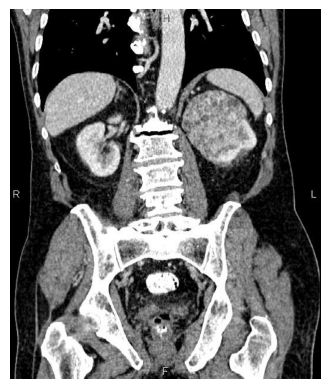

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'Class label: Tumor with Probability: 0.59'

In [ ]:
# Predicting a new image
new_image_path = '/content/kt.jpeg'
new_image = plt.imread(new_image_path)

plt.imshow(new_image,cmap='grey')
plt.axis('off')
plt.show()

predict_image_class(new_image)

In [4]:
!pip install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [8]:
# Gradio interface
interface = gr.Interface(
    fn=predict_image_class,
    inputs=gr.Image(type="pil", label="Upload CT Image"),
    outputs="text",
    title="Kidney Tumor Classification",
    description="Upload a CT image, and the model will predict the class (Tumor, Normal, Stone, or Cyst) along with the probability."
)

# Launch the Gradio app
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0b2d65cf5bd88236a5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
